# Multistate Model (MSM)

## Introduction

This code implements the multistate model (MSM) for charge distribution in radical anion or radical cation states of pi-conjugated oligomeric systems. The MSM is a simple model that describes the charge delocalization in molecular systems using a series of parabolic (or other) potentials. The model is described in the following paper:

 * Talipov, M. R.; Boddeda, A.; Timerghazin, Q. K.; Rathore, R. Key Role of End-Capping Groups in Optoelectronic Properties of Poly- p -Phenylene Cation Radicals. J. Phys. Chem. C 2014, 118 (37), 21400–21408. https://doi.org/10.1021/jp5082752.

The applications of the model are demonstrated e.g. in these papers:
 * Talipov, M. R.; Jasti, R.; Rathore, R. A Circle Has No End: Role of Cyclic Topology and Accompanying Structural Reorganization on the Hole Distribution in Cyclic and Linear Poly-p-Phenylene Molecular Wires. J. Am. Chem. Soc. 2015, 137 (47), 14999–15006. https://doi.org/10.1021/jacs.5b09596.
 * Wang, D.; Talipov, M. R.; Ivanov, M. V.; Rathore, R. Energy Gap between the Poly- p -Phenylene Bridge and Donor Groups Controls the Hole Delocalization in Donor–Bridge–Donor Wires. J. Am. Chem. Soc. 2016, 138 (50), 16337–16344. https://doi.org/10.1021/jacs.6b09209.
 * Talipov, M. R.; Ivanov, M. V.; Rathore, R. Inclusion of Asymptotic Dependence of Reorganization Energy in the Modified Marcus-Based Multistate Model Accurately Predicts Hole Distribution in Poly- p -Phenylene Wires. J. Phys. Chem. C 2016, 120 (12), 6402–6408. https://doi.org/10.1021/acs.jpcc.6b00514.
 * Ivanov, M. V.; Talipov, M. R.; Boddeda, A.; Abdelwahed, S. H.; Rathore, R. Hückel Theory + Reorganization Energy = Marcus–Hush Theory: Breakdown of the 1/ n Trend in π-Conjugated Poly- p -Phenylene Cation Radicals Is Explained. J. Phys. Chem. C 2017, 121 (3), 1552–1561. https://doi.org/10.1021/acs.jpcc.6b12111.
 * Ivanov, M. V.; Chebny, V. J.; Talipov, M. R.; Rathore, R. Poly-p-Hydroquinone Ethers: Isoenergetic Molecular Wires with Length-Invariant Oxidation Potentials and Cation Radical Excitation Energies. J. Am. Chem. Soc. 2017, 139 (12), 4334–4337. https://doi.org/10.1021/jacs.7b01226.

## Code

In [38]:
import numpy as np
import pandas as pd

from scipy.optimize import minimize

import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Helper functions

In [39]:
def plot_charges(data, group_by='FN', value='value', align='left', bar_width=0.25, margin=0.05, bar_color='green',
                 edge_color='black', edge_thickness=1.5):
    """
    Plot charges as a series of bar plots
    
    :param data: data frame with charges
    :param group_by: column name to group by
    :param value: column name with charge values
    :param align: alignment of the bars
    :param bar_width: width of the bars
    :param margin: margin around the bars
    :param bar_color: color of the bars
    :param edge_color: color of the edges
    :param edge_thickness: thickness of the edges
    :return: plot
    """
    charges = data.groupby(group_by)

    max_nbars = max([len(group) for _, group in charges])

    fig, ax = plt.subplots()
    ax.axis('off')
    ax.set_frame_on(False)

    for j, (name, group) in enumerate(charges):
        n_bars = len(group[value])
        # Plotting rectangles
        if align == 'center':
            start_x = (max_nbars - n_bars) * bar_width / 2
        elif align == 'right':
            start_x = (max_nbars - n_bars) * bar_width  # right align
        elif align == 'left':
            start_x = 0
        else:
            start_x = 0

        for i, charge in enumerate(group[value]):
            rect = patches.Rectangle((start_x + i * bar_width, -j), 0.8 * bar_width, charge, edgecolor=edge_color,
                                     facecolor=bar_color)
            rect.set_linewidth(edge_thickness)
            ax.add_patch(rect)

        # Add text on the right from the last rectangle
        #ax.text(start_x + (n_bars + 0.25)*bar_width, 0.07-j, name, fontsize=14, va='center', ha='left')
        # Add text on the left aligned with the bar height
        ax.text(0, -j + max(group[value]), name, fontsize=14, va='top', ha='left')

    ax.set_xlim(-margin, max_nbars + margin)
    ax.set_ylim(-margin - j, 1 + margin)

    # set plot height
    fig.set_figheight(1 + j)
    # set plot width
    fig.set_figwidth(max_nbars)
    # Optionally display the plot
    return plt

In [40]:
# Example of use
#charges = pd.read_csv('spin.ground.txt', sep='\s+', comment='#')
#plt = plot_charges(charges, align='center', bar_color='gold', edge_color='black',edge_thickness=1.5)
# save as pdf
#plt.savefig('spin.ground.pdf', bbox_inches='tight')
#plt.show()

In [41]:
def lean_charges_right(charges):
    """
    If the charge distribution is asymmetric, lean it to the right
    :param charges: charge distribution
    :return: leaned charge distribution
    """
    q = np.array(charges)
    q_rev = np.flip(q)
    indices = np.arange(len(q))
    if q_rev @ indices > q @ indices:
        return q_rev
    return q

### Helper Classes

In [52]:
class Hamiltonian:
    """
    Class for the Hamiltonian matrix for a single x value
    
    No modifications are allowed after the Hamiltonian is solved.
    """

    def __init__(self, n=None):
        self.n = n
        self.H = np.zeros((n, n))
        self.H_x = np.zeros(n)
        self.H_system = np.zeros((n, n))
        self.wf = np.zeros((n, n))
        self.energies = np.zeros(n)
        self.x = None
        self.solved = False

    # decorator to prevent modification of the Hamiltonian after it is solved
    def _check_solved(func):
        def wrapper(self, *args, **kwargs):
            if self.solved:
                raise Exception('No modifications are allowed after the Hamiltonian is solved!')
            return func(self, *args, **kwargs)
        return wrapper

    def _not_solved(func):
        def wrapper(self, *args, **kwargs):
            if not self.solved:
                raise Exception('The Hamiltonian is not solved yet!')
            return func(self, *args, **kwargs)
        return wrapper

    def __repr__(self):
        s = f'Hamiltonian(n={self.n}, x={self.x})'
        if self.n < 10:
            s += '\n---'
            for row in (self.H_system + np.diag(self.H_x)):
                s += '\n' + ' '.join(['%.3f' % el if el != 0 else '  .  ' for el in row])
            s += '\n---'

        if self.solved:
            s += '\nSolved!'
            # show x, ground, and excited states
            s += f'\nGround state: {self.get_energy(1):.3f}'
            s += f'\nExcited state: {self.get_energy(2):.3f}'
            # show charges
            s += '\nCharges:'
            # Show each value in %.2f format
            s += ' '.join(['%.3f' % charge for charge in self.get_charges(1)])
        else:
            s += '\nNot solved'
        return s

    @_check_solved
    def set_H_element(self, i, j, v):
        """
        Symmetrically set the Hamiltonian matrix element
        :param i: column index
        :param j: row index
        :param v: value
        :return: Nothing
        """
        self.H_system[i, j] = self.H_system[j, i] = v

    @_check_solved
    def set_couplings(self, couplings):
        """
        Set couplings between the diabatic states
        Values are set that in each subdiagonal, all elements will be the same.
        Truncated couplings are allowed, e.g. for n = 5, couplings = [1, 2, 3] gives the following Hamiltonian:
            . 1 2 3 .
            . . 1 2 3
            . . . 1 2
            . . . . 1
            . . . . .
        Example input matrix:
            . 1 2 3 4
            . . 1 2 3
            . . . 1 2
            . . . . 1
            . . . . .
        :param couplings: list of couplings
        :return: None
        """
        #assert len(couplings) == self.n - 1, 'Number of couplings must be equal to n - 1'
        # loop over each diagonal
        for i in range(self.n - 1):
            for j in range(i + 1, self.n):
                if j - i - 1 < len(couplings):
                    self.set_H_element(i, j, couplings[j - i - 1])

    @_check_solved
    def set_cp_all(self, cp_all):
        """
        Set all coupling elements
        e.g. cp_all = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] gives the following Hamiltonian:
            . 1 2 3 4
            . . 5 6 7
            . . . 8 9
            . . . . 10
            . . . . .
        :param cp_all: list of coupling elements
        :return: None
        """
        assert len(cp_all) == self.n * (self.n - 1) / 2, 'Number of coupling elements must be equal to n * (n - 1) / 2'
        indices = np.triu_indices_from(self.H_system, 1)
        self.H_system[indices] = cp_all
        self.H_system += self.H_system.T

    @_check_solved
    def set_H(self, H):
        """
        Set the Hamiltonian matrix
        e.g. H = np.array([[0, 1, 2, 3, 4],
                  [1, 0, 5, 6, 7],
                  [2, 5, 0, 8, 9],
                  [3, 6, 8, 0, 10],
                  [4, 7, 9, 10, 0]])
        :param H: Hamiltonian matrix
        :return: None
        """
        assert H.shape == (self.n, self.n), 'Hamiltonian matrix must be of size n x n'
        self.H_system = H.copy()

    @_check_solved
    def shift_ends(self, shift=(0, 0)):
        """
        Shift the first and the last elements of the Hamiltonian matrix
        :param shift: tuple with shift values
        :return: None
        """
        self.set_H_element(0, 0, shift[0])
        self.set_H_element(self.n - 1, self.n - 1, shift[1])

    @_check_solved
    def set_x(self, x, reorg_func='quadratic', Lambda=1.0):
        """
        Set diagonal elements of the Hamiltonian matrix
        :param x: coordinate of charge transfer
        :param reorg_func: reorganization function
        :return: None
        """
        self.x = x
        dist_i_x = np.arange(self.n) - x
        if reorg_func == 'quadratic':
            L = np.full(self.n, Lambda)
            h_ii = L * dist_i_x ** 2
        elif reorg_func == 'gaussian':
            # Not tested in the Python version
            a = 1.0 # lambda_G
            R_infl = 1.0
            b = 1 / (2 * R_infl ** 2)
            h_ii = a * (1 - np.exp(-b * dist_i_x ** 2))
        elif reorg_func == 'nelsen':
            # Not tested in the Python version
            C_nelsen = 0.2
            h_ii = Lambda * dist_i_x ** 2 / (1 + C_nelsen) * (1 + C_nelsen * dist_i_x ** 2)
        elif reorg_func == 'quad.1r':
            # Not tested in the Python version
            t = 1
            L = 1 / (3 * t ** 2)
            h_ii = np.where(np.abs(dist_i_x) > t,
                            1 - 2 * L * t ** 3 / np.abs(dist_i_x),
                            L * dist_i_x ** 2)
        self.H_x = h_ii

    @_check_solved
    def solve(self):
        """
        Solve the eigenvalue problem
        :return: eigenvalues and eigenvectors
        """
        self.H = self.H_system + np.diag(self.H_x)
        self.energies, self.wf = np.linalg.eigh(self.H)
        self.solved = True

    @_not_solved
    def get_charges(self, state=1, lean_right=True):
        """
        Get charges of the state
        :param state: state index, starting from 1
        :return: charges
        """
        charges = self.wf[:, state - 1] ** 2
        if lean_right:
            return lean_charges_right(charges)
        
        return charges

    @_not_solved
    def get_energy(self, state=1):
        """
        Get energy of the state
        :param state: state index, starting from 1
        :return: energies
        """
        return self.energies[state - 1]

In [53]:
class Oligomer:
    """
    Represents solution on a range of x values
    """

    def __init__(self, n, dx=0.05, x_beyond=0.5, Lambda = 1.0):
        self.n = n
        self.xrange = np.arange(-x_beyond, n - 1 + x_beyond, dx)
        self.N = len(self.xrange)
        self.Hamiltonians = np.array([None,] * self.N)
        self.solved = False
        self.H_system = np.zeros((self.N, self.N))
        self.Lambda = Lambda

    def _check_solved(func):
        def wrapper(self, *args, **kwargs):
            if self.solved:
                raise Exception('No modifications are allowed after the Hamiltonian is solved!')
            return func(self, *args, **kwargs)
        return wrapper

    def _not_solved(func):
        def wrapper(self, *args, **kwargs):
            if not self.solved:
                raise Exception('The Hamiltonian is not solved yet!')
            return func(self, *args, **kwargs)
        return wrapper

    def __repr__(self):
        s = f'Oligomer(n_units={self.n}, N_x={self.N})'
        if self.solved:
            s += '\nSolved!'
            # show x_range
            s += f'\nx_range: from {self.xrange[0]:.3f} to {self.xrange[-1]:.3f} with step {self.xrange[1] - self.xrange[0]:.3f}'
            
            # show x, ground, and excited states
            global_min_index = self.global_minimum(1)[0]
            
            s += f'\nGlobal minimum: {self.xrange[global_min_index]:.3f}'
            
            s += f'\nGround state: {self.get_minima(1)[2][0]:.3f} eV'
            s += f'\nExcited state: {self.get_minima(2)[2][0]:.3f} eV'
            # show charges
            s += '\nCharges:'
            # Show each value in %.2f format
            s += ' '.join(['%.3f' % charge for charge in self[global_min_index].get_charges(1)])
            
        else:
            s += '\nNot solved'
        return s
    
    @_check_solved
    def set_H_system(self, H_system):
        """
        Set the Hamiltonian matrix
        e.g. H = np.array([[0, 1, 2, 3, 4],
                  [1, 0, 5, 6, 7],
                  [2, 5, 0, 8, 9],
                  [3, 6, 8, 0, 10],
                  [4, 7, 9, 10, 0]])
        :param H: Hamiltonian matrix
        :return: None
        """
        self.H_system = H_system.copy()

    @_check_solved
    def solve(self):
        """
        Solve the eigenvalue problem for each x value
        :return: None
        """
        for i, x in enumerate(self.xrange):
            self.Hamiltonians[i] = Hamiltonian(n=self.n)
            self.Hamiltonians[i].set_x(x, Lambda=self.Lambda)
            self.Hamiltonians[i].set_H(self.H_system)
            self.Hamiltonians[i].solve()
        self.solved = True

    @_not_solved
    # get Hamiltonian by index
    def __getitem__(self, i):
        return self.Hamiltonians[i]

    @_not_solved
    def get_state_curve(self, state=1):
        """
        Get energy of the state as a function of x
        :param state: state index, starting from 1
        :return: energies
        """
        return np.array([H.get_energy(state) for H in self.Hamiltonians])

    @_not_solved
    def get_minima(self, state=1):
        """
        Get global minimum of the state
        :param state: state index, starting from 1
        :return: energies
        """
        # get energies of the ground state
        energies = self.get_state_curve(state)
        global_min = np.argmin(energies)
        local_minima = np.r_[True, energies[1:] < energies[:-1]] & np.r_[energies[:-1] < energies[1:], True]
        # return indices, x values, and energies of the local minima
        return np.where(local_minima)[0], self.xrange[local_minima], energies[local_minima]

    @_not_solved
    def global_minimum(self, state=1):
        """
        Get global minimum of the state
        :param state: state index, starting from 1
        :return: energies
        """
        # get energies of the ground state
        energies = self.get_state_curve(state)
        global_min = np.argmin(energies)
        return global_min, self.xrange[global_min], energies[global_min]

## Examples of use

### Solve the for an Oligomer for a single x value

In [54]:
H = Hamiltonian(n=5)
H.set_couplings([1,])
H.set_x(2, reorg_func='quadratic')
H.solve()

print(H)

Hamiltonian(n=5, x=2)
---
4.000 1.000   .     .     .  
1.000 1.000 1.000   .     .  
  .   1.000   .   1.000   .  
  .     .   1.000 1.000 1.000
  .     .     .   1.000 4.000
---
Solved!
Ground state: -1.069
Excited state: 0.697
Charges:0.007 0.179 0.628 0.179 0.007


### Single oligomer for range of x values

In [55]:
Ham = Hamiltonian(n=5)
Ham.set_couplings([-9.0,])
Ham.shift_ends((-3.7, -3.7))

Hs = Oligomer(n=5)
Hs.set_H_system(Ham.H_system) # coupling matrix, reorganization not included
Hs.solve()

print(Hs)

Oligomer(n_units=5, N_x=100)
Solved!
x_range: from -0.500 to 4.450 with step 0.050
Global minimum: 2.000
Ground state: -15.046 eV
Excited state: -8.357 eV
Charges:0.084 0.243 0.347 0.243 0.084


### Series of oligomers

In [56]:
oligomers_n = [2, 3, 4, 5, 6, 7, 8, 9, 10]
oligomers = []
for n in oligomers_n:
    Ham = Hamiltonian(n=n)
    Ham.set_couplings([-9.0,])
    Ham.shift_ends((-3.7, -3.7))

    Hs = Oligomer(n=n)
    Hs.set_H_system(Ham.H_system)
    Hs.solve()

    oligomers.append(Hs)

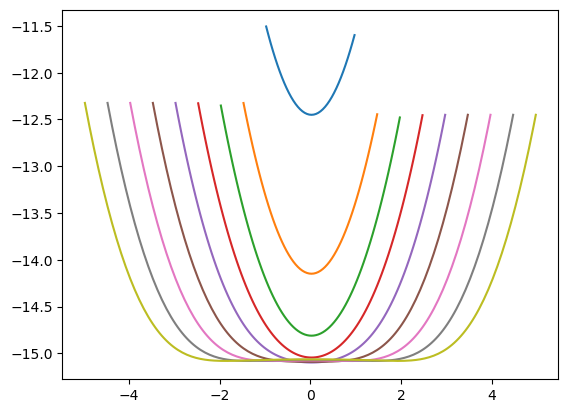

In [57]:
# make a plot of the ground state energy vs x
for i, oligomer in enumerate(oligomers):
    plt.plot(oligomer.xrange - oligomer.xrange.mean(), oligomer.get_state_curve(1), label=f'{oligomers_n[i]}')

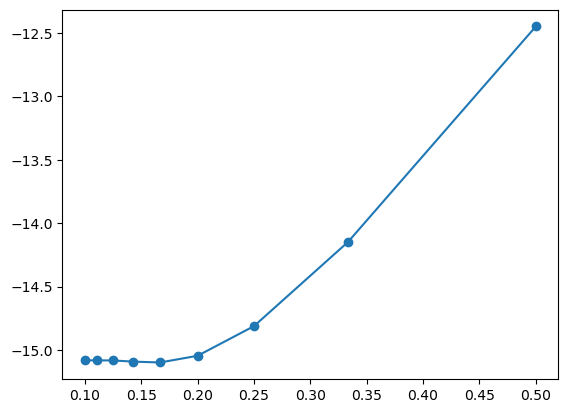

In [58]:
# make a plot of global_min energy vs 1/n
global_min = np.array([oligomer.global_minimum(1)[2] for oligomer in oligomers])
plt.plot(1 / np.array(oligomers_n), global_min, 'o-')

In [59]:
# make a data frame of charge distribution in the ground state at global minimum

# 1. get the indices of the global minima
global_min_indices = np.array([oligomer.global_minimum(1)[0] for oligomer in oligomers])
# 2. get the charges at the global minima as a data frame in the long format for the first oligomer
# where first column represents the oligomer length, second the index of the unit from 1 to n, and third the charge
charges = pd.DataFrame({'n': oligomers_n[0], 'FN': np.arange(1, oligomers_n[0] + 1), 'value': oligomers[0][global_min_indices[0]].get_charges(1)})
# 3. Do it for each oligomer
charges = [None,] * len(oligomers)
for i, oligomer in enumerate(oligomers):
    charges[i] = pd.DataFrame({'n': oligomers_n[i], 'i': np.arange(1, oligomers_n[i] + 1), 'value': oligomers[i][global_min_indices[i]].get_charges(1)})

# 4. Concatenate all data frames
charges_df = pd.concat(charges)

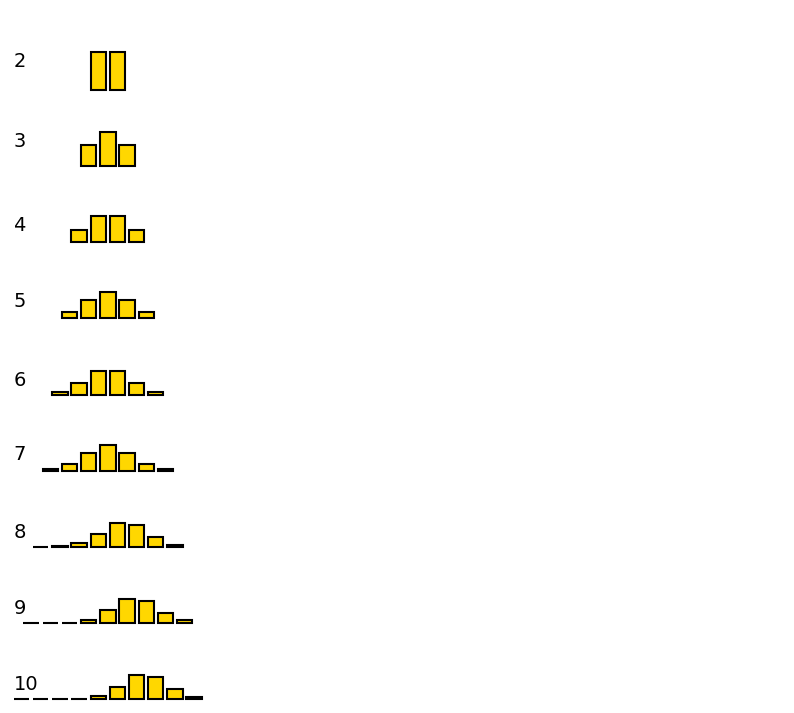

In [60]:
# Make a plot of the charge distribution for the ground state at the global minimum for each oligomer
plt = plot_charges(charges_df, group_by='n', align='center', bar_color='gold', edge_color='black',edge_thickness=1.5)
# Show plot
plt.show()

In [61]:
# save charges_df to csv
charges_df.to_csv('charges.csv', index=False)

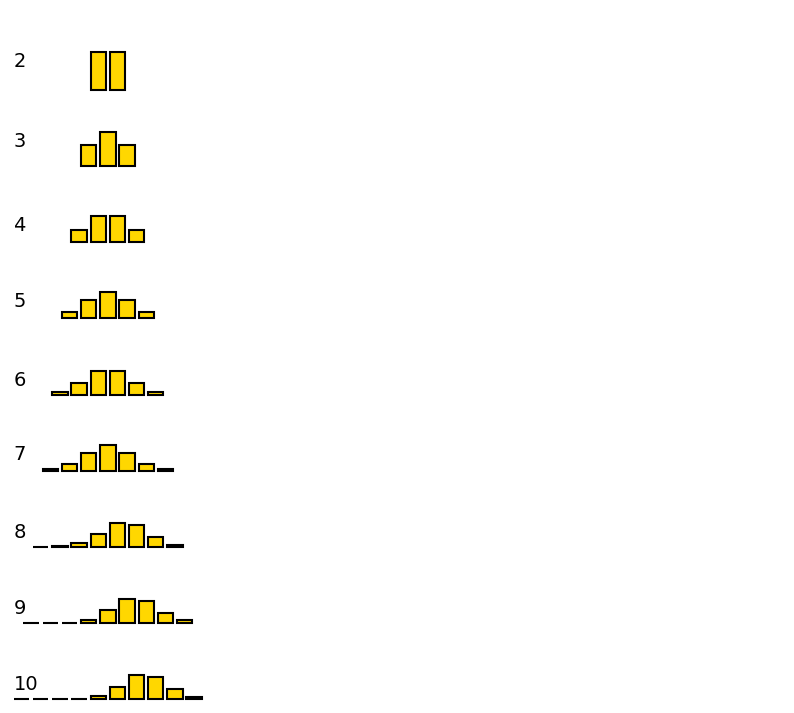

In [62]:
# read charges_df from csv
q = pd.read_csv('charges.csv')

# Make a plot of the charge distribution for the ground state at the global minimum for each oligomer
plt = plot_charges(q, group_by='n', align='center', bar_color='gold', edge_color='black',edge_thickness=1.5)
# Save as pdf
plt.savefig('charges.pdf', bbox_inches='tight')
# Show plot
plt.show()

In [63]:
q.head()

,n,i,value
0,2,1,0.500000
1,2,2,0.500000
2,3,1,0.276369
3,3,2,0.447263
4,3,3,0.276369


## Fit the coupling to reproduce data from csv file

In [64]:
def generate_oligomers(n, coupling, term_shift):
    """
    Generate oligomers for a range of units from 2 to n with a given coupling and term shift
    :param n: maximum number of units
    :param coupling: coupling between the units
    :param term_shift: shift of the ends
    :return: list of oligomers, each oligomer is an instance of the Oligomer class
    """
    oligomers_n = range(2, n + 1)
    oligomers = []
    for n in oligomers_n:
        Ham = Hamiltonian(n=n)
        Ham.set_couplings([coupling,])
        Ham.shift_ends(term_shift)

        Hs = Oligomer(n=n)
        Hs.set_H_system(Ham.H_system)
        Hs.solve()

        oligomers.append(Hs)

    return oligomers

# Example of use
# oligomers = generate_oligomers(10, -9.0, -3.5)

In [77]:
def generate_oligomers_PF(from_n, to_n, coupling_angle, coupling_flat, term_shift):
    """
    Same as generate_oligomers, but with alternating couplings between adjacent units
    """
    oligomers_n = range(from_n, to_n + 1)
    oligomers = []
    for n in oligomers_n:
        H = np.zeros((2*n, 2*n))
        # set super diagonal elements to 1
        np.fill_diagonal(H[1:], (coupling_flat,coupling_angle))
        # set sub diagonal elements to 1
        np.fill_diagonal(H[:,1:], (coupling_flat, coupling_angle))

        Ham = Hamiltonian(n=2*n)
        Ham.set_H(H)
        Ham.shift_ends(term_shift)

        Hs = Oligomer(n=2*n)
        Hs.set_H_system(Ham.H_system)
        Hs.solve()

        oligomers.append(Hs)

    return oligomers

# Example of use
#og = generate_oligomers_PF(3, -15.0, -16.0, (0, 0))

In [78]:
def get_oligomers_charges(oligomers):
    """
    Get charges at the global minimum for each oligomer
    :param oligomers: list of oligomers, each oligomer is an instance of the Oligomer class
    :return: data frame with charges
    """
    charges = [None,] * len(oligomers)
    for i, oligomer in enumerate(oligomers):
        global_min_index = oligomer.global_minimum(1)[0]
        q = oligomer[global_min_index].get_charges(1)
        charges[i] = pd.DataFrame(
            {'n': len(q), 
             'i': np.arange(1, len(q) + 1), 
             'value': q})
    return pd.concat(charges)

In [85]:
data_oligomers = {
    'H-Pn-H': 
        {'fname':'data/H-Pn-H.csv', 'gen_o': lambda p: generate_oligomers(12, p[0], [0, 0])},
    'H-Pn-CHO': 
        {'fname':'data/H-Pn-CHO.csv', 'gen_o': lambda p: generate_oligomers(8, p[0], [0, p[1]])},
    'CHO-Pn-CHO': 
        {'fname':'data/CHO-Pn-CHO.csv', 'gen_o': lambda p: generate_oligomers(8, p[0], [p[1], p[1]])},
    
    'H-Ln-H-iPr_Bridge': 
        {'fname':'data/H-Ln-H-iPr_Bridge.csv', 'gen_o': lambda p: generate_oligomers(12, p[2], [0, 0])},
    'H-Ln-CHO-iPr_Bridge': 
        {'fname':'data/H-Ln-CHO-iPr_Bridge.csv', 'gen_o': lambda p: generate_oligomers(8, p[2], [0, p[1]])},

    'H-Ln-H': 
        {'fname':'data/H-Ln-H.csv', 'gen_o': lambda p: generate_oligomers(12, p[2], [0, 0])},
    'H-Ln-CHO': 
        {'fname':'data/H-Ln-CHO.csv', 'gen_o': lambda p: generate_oligomers(8, p[2], [0, p[1]])},
    'CHO-Ln-CHO': 
        {'fname':'data/CHO-Ln-CHO.csv', 'gen_o': lambda p: generate_oligomers(8, p[2], [p[1], p[1]])},

    'H-PFn-H': 
        {'fname':'data/H-PFn-H.csv', 'gen_o': lambda p: generate_oligomers_PF(1, 4, p[0], p[2], [0, 0])},
    'H-PFn-CHO': 
        {'fname':'data/H-PFn-CHO.csv', 'gen_o': lambda p: generate_oligomers_PF(2, 4, p[0], p[2], [0, p[1]])},
    'CHO-PFn-CHO': 
        {'fname':'data/CHO-PFn-CHO.csv', 'gen_o': lambda p: generate_oligomers_PF(1, 4, p[0], p[2], [p[1], p[1]])},
                  }

In [86]:
# Read and combine charges, computed using DFT, from csv files
for name_o, data_o in data_oligomers.items():
    q_pn = pd.read_csv(data_o['fname'])
    q_pn['value'] = q_pn['Dgeom']
    # for each oligomer in q_pn, lean charges right
    q_pn['value'] = q_pn.groupby('oligomer')['value'].transform(lean_charges_right)
    data_o['target_vals'] = np.array(q_pn['value'])
    data_o['d'] = q_pn

In [87]:
def compute_target2(data_oligomers, oligomers_to_use, coupling_angle, term_shift, coupling_flat):
    """
    Compute the loss function for the optimization
    """
    diffs = np.array([])
    for o in oligomers_to_use:
        data_o = data_oligomers[o]
        oligomers = data_o['gen_o']([coupling_angle, term_shift, coupling_flat])
        q_mpm = get_oligomers_charges(oligomers)
        o_diffs = np.array(q_mpm['value']) - data_o['target_vals']
        diffs = np.concatenate((diffs, o_diffs))        
    
    target = np.sqrt((diffs ** 2).mean())
    return target

In [88]:
%%time
# Should take ~ 3 min
oligomers_to_use = ['H-Pn-H', 'H-Pn-CHO', 'CHO-Pn-CHO', 
                    'H-Ln-H', 'H-Ln-CHO', 'CHO-Ln-CHO',
                    'H-PFn-H', 'H-PFn-CHO', 'CHO-PFn-CHO'
                    ]

#oligomers_to_use = ['H-PFn-H']
res = minimize(lambda p: compute_target2(data_oligomers, oligomers_to_use, *p), x0=[-15, -37, -15], method='Nelder-Mead')
res

CPU times: user 2min 37s, sys: 112 ms, total: 2min 38s
Wall time: 2min 37s


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.01648529234039785
             x: [-1.988e+01 -5.234e+01 -2.071e+01]
           nit: 178
          nfev: 341
 final_simplex: (array([[-1.988e+01, -5.234e+01, -2.071e+01],
                       [-1.988e+01, -5.234e+01, -2.071e+01],
                       [-1.988e+01, -5.234e+01, -2.071e+01],
                       [-1.988e+01, -5.234e+01, -2.071e+01]]), array([ 1.649e-02,  1.649e-02,  1.649e-02,  1.649e-02]))

In [91]:
print('Optimization results')
print('RMSD between the DFT and MSM charges:')
for o in oligomers_to_use:
    result = compute_target2(data_oligomers, [o, ], *res['x'])
    print(f'{o}: {result:.3f} q')

Optimization results
RMSD between the DFT and MSM charges:
H-Pn-H: 0.012 q
H-Pn-CHO: 0.010 q
CHO-Pn-CHO: 0.013 q
H-Ln-H: 0.024 q
H-Ln-CHO: 0.016 q
CHO-Ln-CHO: 0.020 q
H-PFn-H: 0.010 q
H-PFn-CHO: 0.011 q
CHO-PFn-CHO: 0.011 q


In [94]:
print('Optimal parameters:')

coupling_angle, term_shift, coupling_flat = res['x']
print(f'coupling_angle: {coupling_angle:.3f}')
print(f'term_shift: {term_shift:.3f}')
print(f'coupling_flat: {coupling_flat:.3f}')


Optimal parameters:
coupling_angle: -19.879
term_shift: -52.336
coupling_flat: -20.707


Done


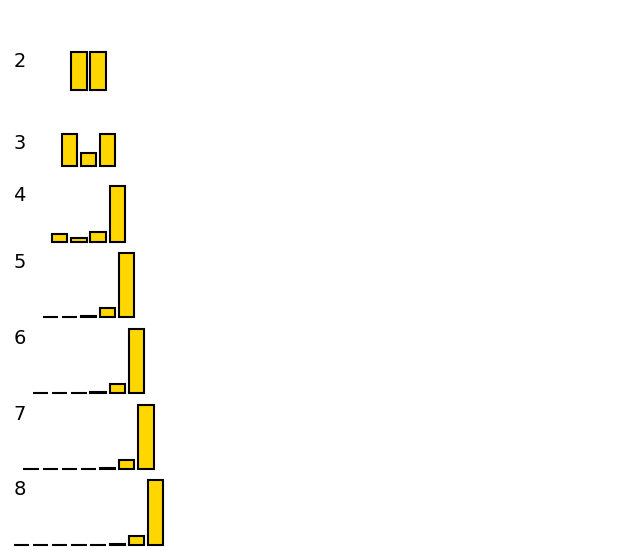

In [103]:
# Generate the bar plots of charges from MSM based on the optimal parameters
os = data_oligomers['CHO-Ln-CHO']['gen_o'](res['x'])
q_mpm = get_oligomers_charges(os)
plt = plot_charges(q_mpm, group_by='n', align='center', bar_color='gold', edge_color='black',edge_thickness=1.5)

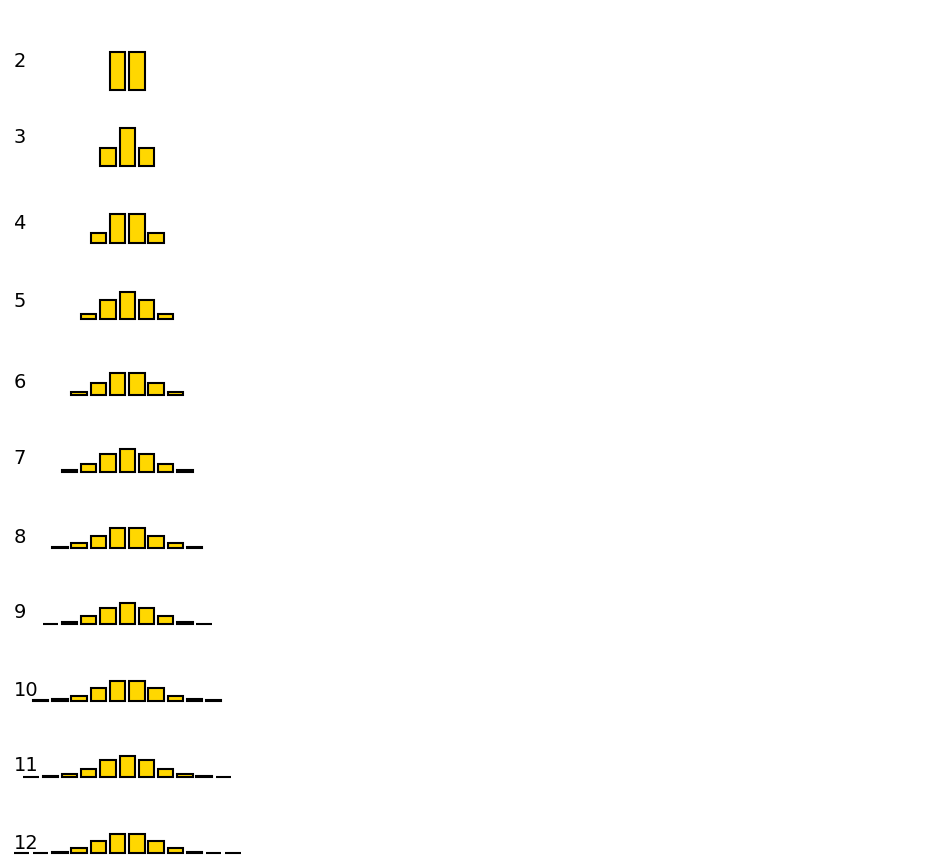

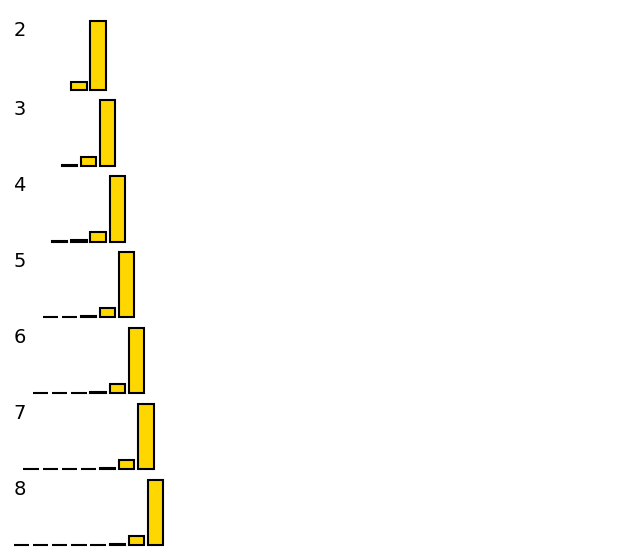

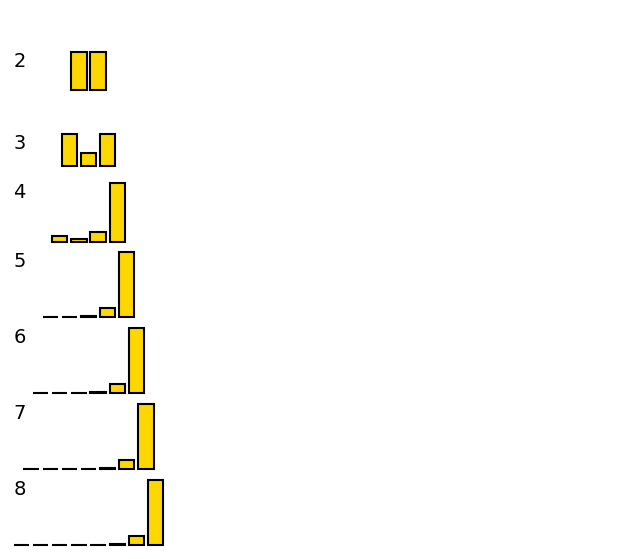

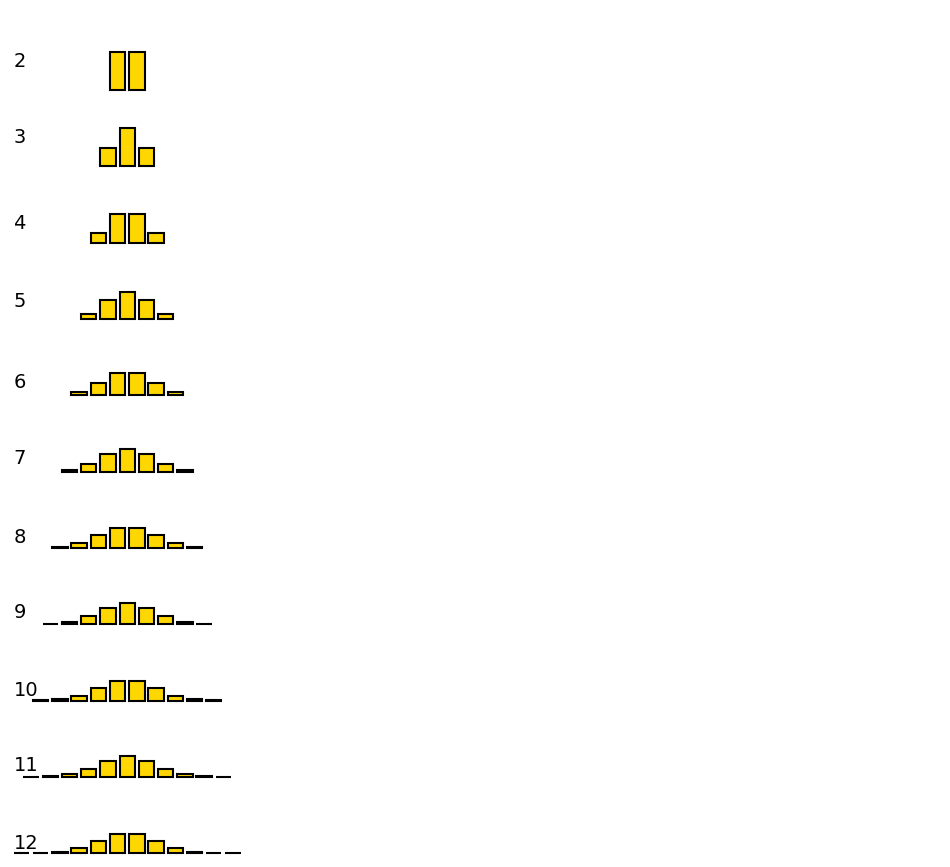

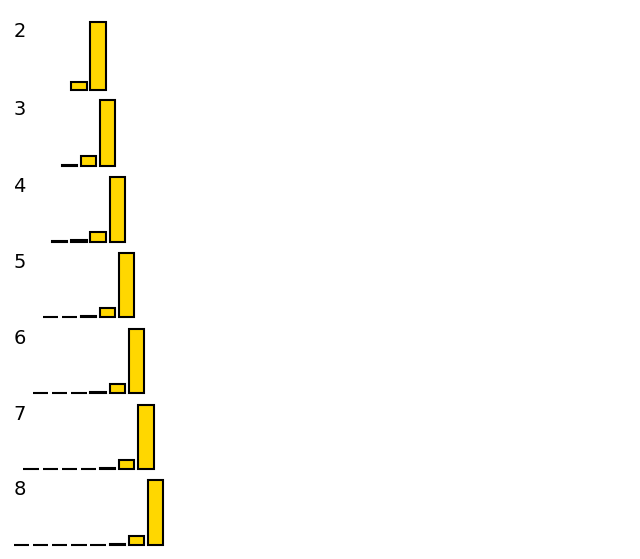

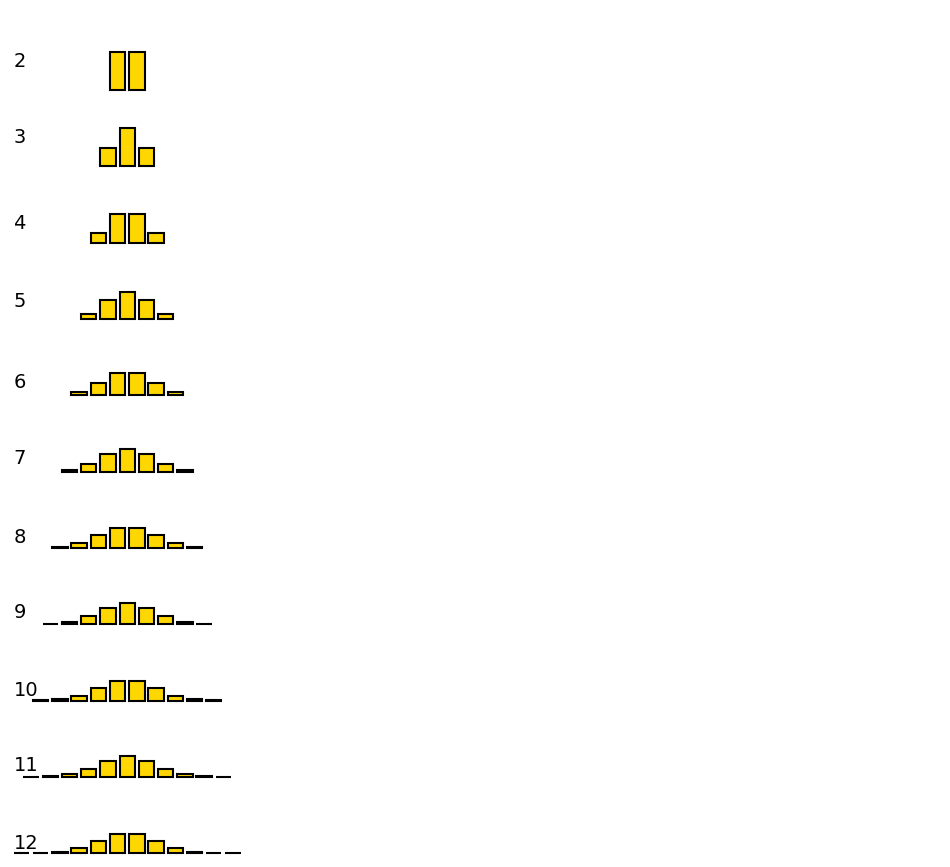

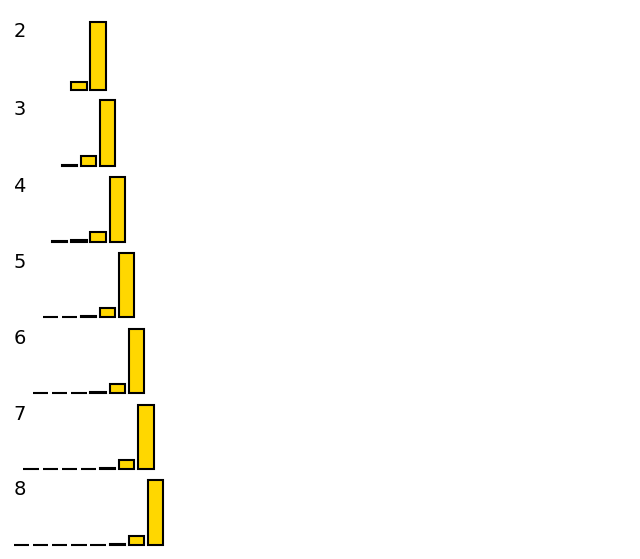

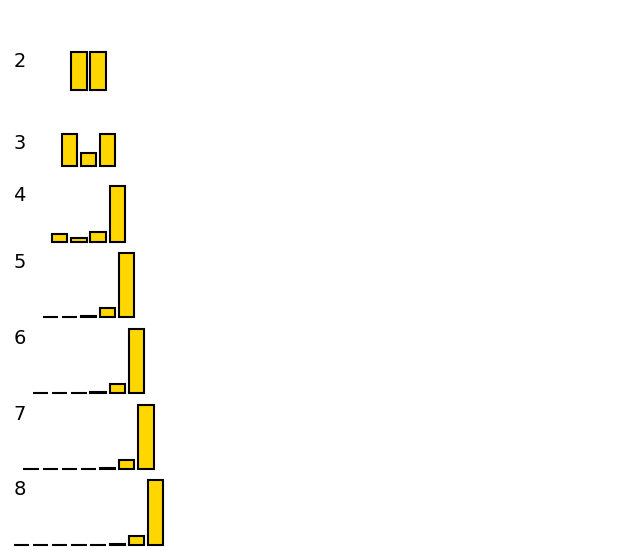

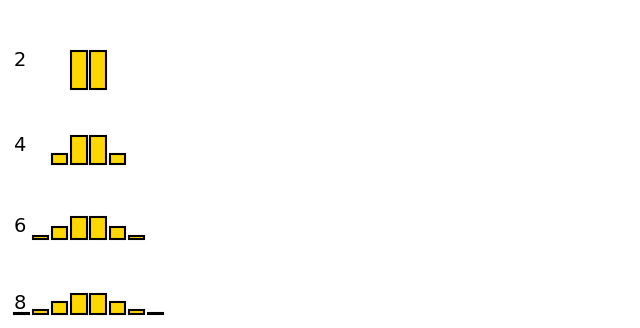

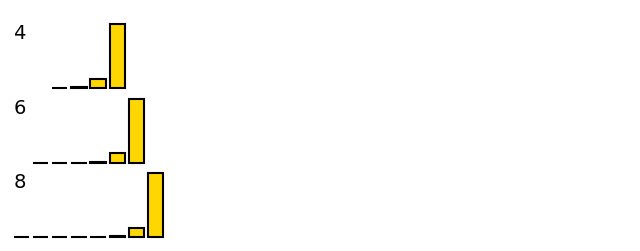

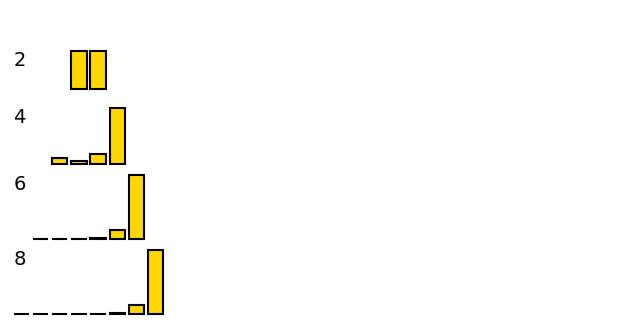

In [101]:
# Save the bar plots of charges from MSM based on the optimal parameters 
for d in data_oligomers.keys():
    os = data_oligomers[d]['gen_o'](res['x'])
    q_mpm = get_oligomers_charges(os)
    plt = plot_charges(q_mpm, group_by='n', align='center', bar_color='gold', edge_color='black',edge_thickness=1.5)
    plt.savefig(f'{d}.pdf', bbox_inches='tight')


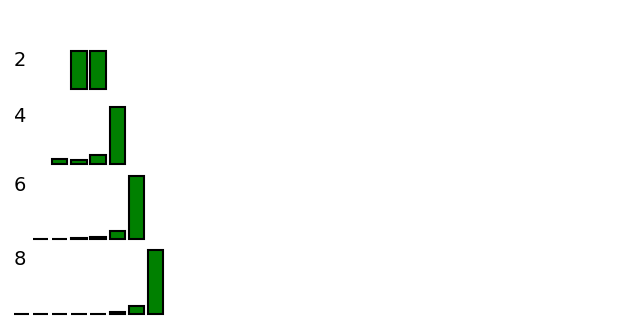

In [399]:
# Look at the charge bar plots from the DFT calculations
d = data_oligomers['CHO-PFn-CHO']['d']
d['n'] = d.groupby('oligomer')['oligomer'].transform('count')

plt2 = plot_charges(d, group_by='n', align='center', bar_color='green', edge_color='black',edge_thickness=1.5)
plt2.show()